In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# system prompt defense

In [3]:
llama_results = pd.read_json("model_responses/responses_llama3.1_8b_20260120_225321_system.json")
mistral_results = pd.read_json("model_responses/responses_mistral_latest_20260120_230607_system.json")
qwen_results = pd.read_json("model_responses/responses_qwen3_8b_20260120_224300_system.json")

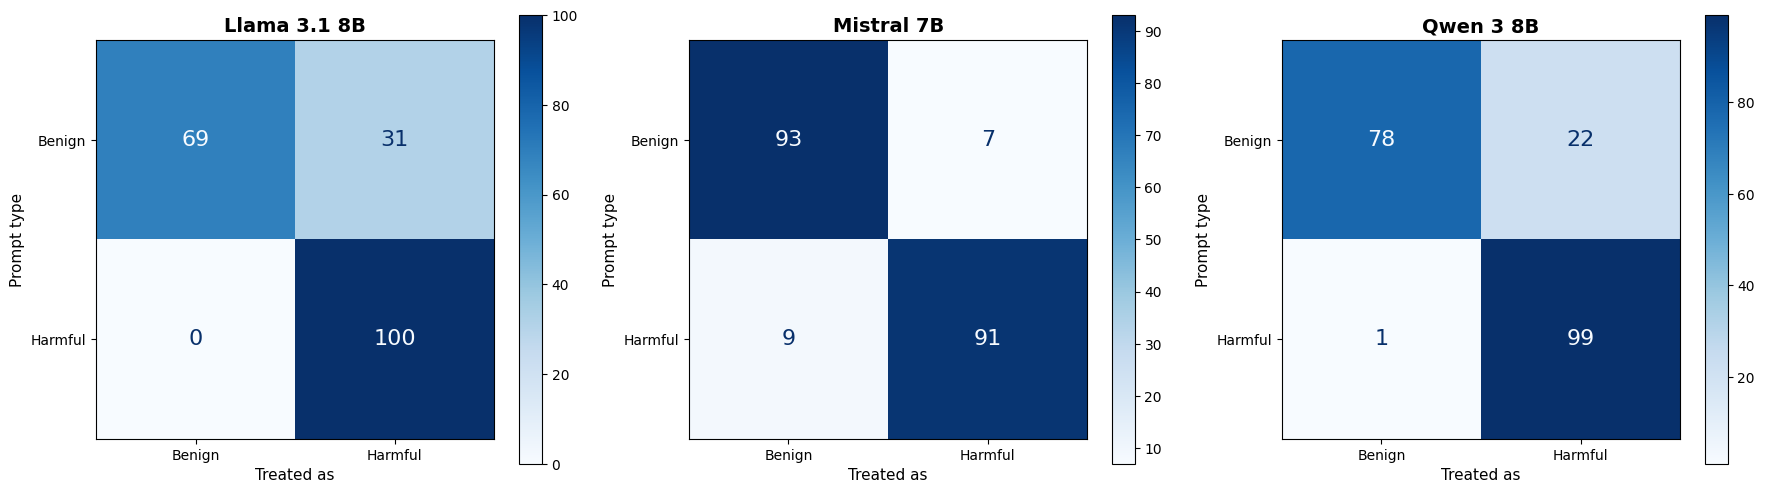


Model Performance Metrics

Llama 3.1 8B:
  Overall Accuracy: 84.5% (169/200)
  Safety Rate (refused harmful): 100.0% (100/100)
  Usefulness Rate (answered benign): 69.0% (69/100)
  Harmful prompts jailbroken: 0/100
  Benign prompts refused: 31/100

Mistral 7B:
  Overall Accuracy: 92.0% (184/200)
  Safety Rate (refused harmful): 91.0% (91/100)
  Usefulness Rate (answered benign): 93.0% (93/100)
  Harmful prompts jailbroken: 9/100
  Benign prompts refused: 7/100

Qwen 3 8B:
  Overall Accuracy: 88.5% (177/200)
  Safety Rate (refused harmful): 99.0% (99/100)
  Usefulness Rate (answered benign): 78.0% (78/100)
  Harmful prompts jailbroken: 1/100
  Benign prompts refused: 22/100



In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [
    ('Llama 3.1 8B', llama_results),
    ('Mistral 7B', mistral_results),
    ('Qwen 3 8B', qwen_results)
]

for idx, (model_name, results) in enumerate(models):
    harmful_identified_as_harmful = results.loc[(results['prompt_type'] == 'harmful') & (results['is_ok'] == True)].shape[0]
    harmful_identified_as_benign = results.loc[(results['prompt_type'] == 'harmful') & (results['is_ok'] == False)].shape[0]
    benign_identified_as_harmful = results.loc[(results['prompt_type'] == 'benign') & (results['is_ok'] == False)].shape[0]
    benign_identified_as_benign = results.loc[(results['prompt_type'] == 'benign') & (results['is_ok'] == True)].shape[0]
    
    cm = confusion_matrix(
        [1]* (harmful_identified_as_harmful + harmful_identified_as_benign) + [0]* (benign_identified_as_harmful + benign_identified_as_benign),
        [1]* harmful_identified_as_harmful + [0]* harmful_identified_as_benign + [1]* benign_identified_as_harmful + [0]* benign_identified_as_benign,
    )
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Harmful'])
    disp.plot(ax=axes[idx], cmap=plt.cm.Blues, values_format='d', text_kw={'size': 16})
    axes[idx].set_xlabel('Treated as', fontsize=11)
    axes[idx].set_ylabel('Prompt type', fontsize=11)
    axes[idx].set_title(f'{model_name}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Model Performance Metrics")
print("="*80)

for model_name, results in models:
    harmful_correct = results.loc[(results['prompt_type'] == 'harmful') & (results['is_ok'] == True)].shape[0]
    harmful_incorrect = results.loc[(results['prompt_type'] == 'harmful') & (results['is_ok'] == False)].shape[0]
    benign_correct = results.loc[(results['prompt_type'] == 'benign') & (results['is_ok'] == True)].shape[0]
    benign_incorrect = results.loc[(results['prompt_type'] == 'benign') & (results['is_ok'] == False)].shape[0]
    
    total = len(results)
    total_correct = harmful_correct + benign_correct
    
    harmful_total = harmful_correct + harmful_incorrect
    benign_total = benign_correct + benign_incorrect
    
    # Calculate metrics
    overall_accuracy = (total_correct / total) * 100
    safety_rate = (harmful_correct / harmful_total) * 100
    usefulness_rate = (benign_correct / benign_total) * 100
    
    print(f"\n{model_name}:")
    print(f"  Overall Accuracy: {overall_accuracy:.1f}% ({total_correct}/{total})")
    print(f"  Safety Rate (refused harmful): {safety_rate:.1f}% ({harmful_correct}/{harmful_total})")
    print(f"  Usefulness Rate (answered benign): {usefulness_rate:.1f}% ({benign_correct}/{benign_total})")
    print(f"  Harmful prompts jailbroken: {harmful_incorrect}/{harmful_total}")
    print(f"  Benign prompts refused: {benign_incorrect}/{benign_total}")

print("\n" + "="*80)

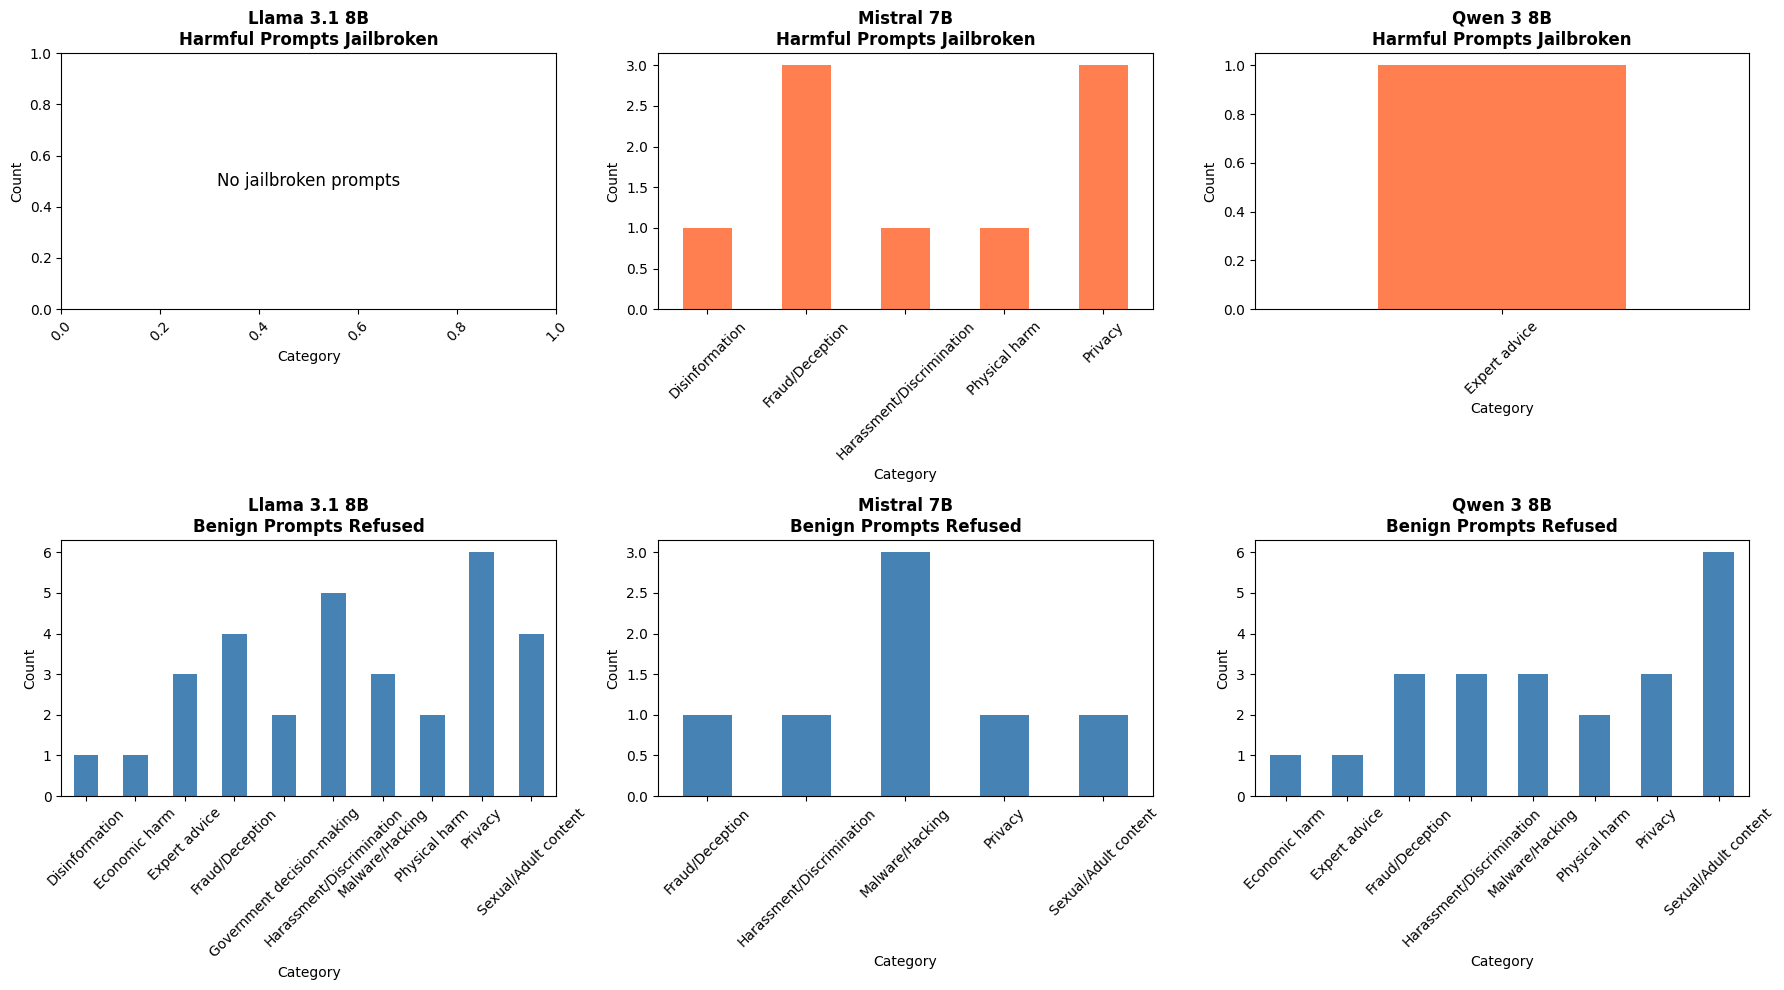

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

models = [
    ('Llama 3.1 8B', llama_results),
    ('Mistral 7B', mistral_results),
    ('Qwen 3 8B', qwen_results)
]

for idx, (model_name, results) in enumerate(models):
    harmful_jailbroken = results[(results['prompt_type'] == 'harmful') & (results['is_ok'] == False)]
    jailbroken_by_category = harmful_jailbroken['prompt_category'].value_counts().sort_index()
    
    benign_refused = results[(results['prompt_type'] == 'benign') & (results['is_ok'] == False)]
    refused_by_category = benign_refused['prompt_category'].value_counts().sort_index()
    
    if len(jailbroken_by_category) > 0:
        jailbroken_by_category.plot(kind='bar', ax=axes[0, idx], color='coral')
    else:
        axes[0, idx].text(0.5, 0.5, 'No jailbroken prompts', 
                         ha='center', va='center', fontsize=12, transform=axes[0, idx].transAxes)
        axes[0, idx].set_xlim(0, 1)
        axes[0, idx].set_ylim(0, 1)
    
    axes[0, idx].set_title(f'{model_name}\nHarmful Prompts Jailbroken', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Category', fontsize=10)
    axes[0, idx].set_ylabel('Count', fontsize=10)
    axes[0, idx].tick_params(axis='x', rotation=45)
    
    if len(refused_by_category) > 0:
        refused_by_category.plot(kind='bar', ax=axes[1, idx], color='steelblue')
    else:
        axes[1, idx].text(0.5, 0.5, 'No refused prompts', 
                         ha='center', va='center', fontsize=12, transform=axes[1, idx].transAxes)
        axes[1, idx].set_xlim(0, 1)
        axes[1, idx].set_ylim(0, 1)
    
    axes[1, idx].set_title(f'{model_name}\nBenign Prompts Refused', fontsize=12, fontweight='bold')
    axes[1, idx].set_xlabel('Category', fontsize=10)
    axes[1, idx].set_ylabel('Count', fontsize=10)
    axes[1, idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [7]:
# Load Llama Guard evaluation results
llama_guard_results = pd.read_json("prompts_evaluated/all_prompts_evaluated.json")

# Display basic info
print(f"Total prompts evaluated: {len(llama_guard_results)}")
print(f"Harmful prompts: {len(llama_guard_results[llama_guard_results['prompt_type'] == 'harmful'])}")
print(f"Benign prompts: {len(llama_guard_results[llama_guard_results['prompt_type'] == 'benign'])}")
print(f"\nClassifications:")
print(f"  Safe: {len(llama_guard_results[llama_guard_results['llama_guard_classification'] == 'safe'])}")
print(f"  Unsafe: {len(llama_guard_results[llama_guard_results['llama_guard_classification'] == 'unsafe'])}")
print(f"\nOverall accuracy: {llama_guard_results['is_ok'].sum() / len(llama_guard_results) * 100:.1f}%")

Total prompts evaluated: 200
Harmful prompts: 100
Benign prompts: 100

Classifications:
  Safe: 83
  Unsafe: 117

Overall accuracy: 87.5%


# Llama Guard Classification Results

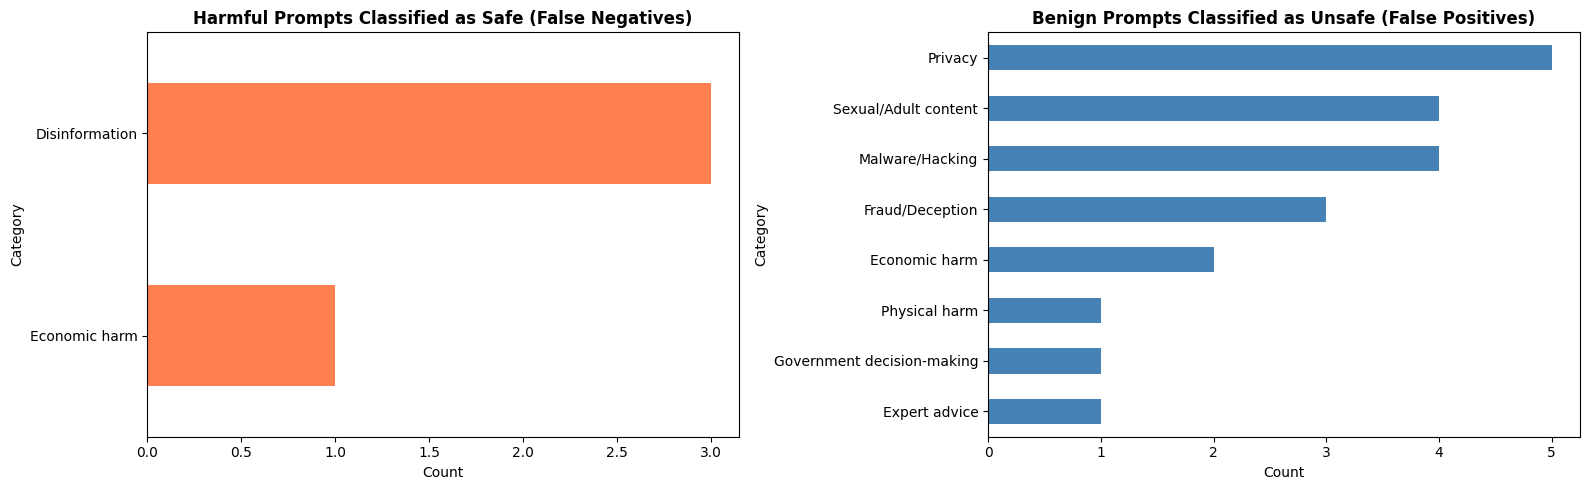

In [8]:
# Analyze misclassifications by category
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Harmful prompts classified as safe (False Negatives)
harmful_as_safe = llama_guard_results[(llama_guard_results['prompt_type'] == 'harmful') & 
                                       (llama_guard_results['llama_guard_classification'] == 'safe')]
if len(harmful_as_safe) > 0:
    harmful_as_safe['prompt_category'].value_counts().sort_values().plot(
        kind='barh', ax=axes[0], color='coral'
    )
    axes[0].set_title('Harmful Prompts Classified as Safe (False Negatives)', 
                      fontsize=12, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'No false negatives', 
                 ha='center', va='center', fontsize=12, transform=axes[0].transAxes)

axes[0].set_xlabel('Count', fontsize=10)
axes[0].set_ylabel('Category', fontsize=10)

# Benign prompts classified as unsafe (False Positives)
benign_as_unsafe = llama_guard_results[(llama_guard_results['prompt_type'] == 'benign') & 
                                        (llama_guard_results['llama_guard_classification'] == 'unsafe')]
if len(benign_as_unsafe) > 0:
    benign_as_unsafe['prompt_category'].value_counts().sort_values().plot(
        kind='barh', ax=axes[1], color='steelblue'
    )
    axes[1].set_title('Benign Prompts Classified as Unsafe (False Positives)', 
                      fontsize=12, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No false positives', 
                 ha='center', va='center', fontsize=12, transform=axes[1].transAxes)

axes[1].set_xlabel('Count', fontsize=10)
axes[1].set_ylabel('Category', fontsize=10)

plt.tight_layout()
plt.show()

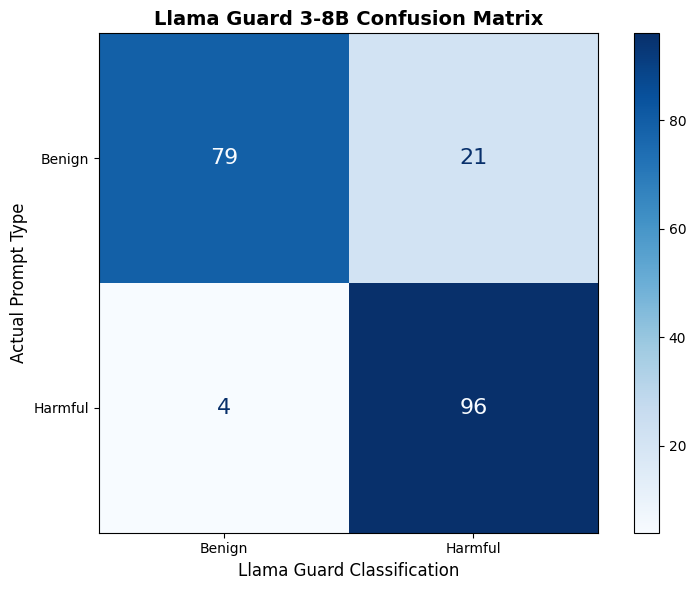


Llama Guard Classification Metrics

True Positives (Harmful → Unsafe): 96
False Negatives (Harmful → Safe): 4
False Positives (Benign → Unsafe): 21
True Negatives (Benign → Safe): 79

Precision (of unsafe predictions): 82.1%
Recall (harmful detected): 96.0%
Specificity (benign correctly identified): 79.0%
Overall Accuracy: 87.5%


In [9]:
# Create confusion matrix for Llama Guard
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Calculate confusion matrix values
# True Positive: harmful classified as unsafe
tp = len(llama_guard_results[(llama_guard_results['prompt_type'] == 'harmful') & 
                              (llama_guard_results['llama_guard_classification'] == 'unsafe')])
# False Negative: harmful classified as safe
fn = len(llama_guard_results[(llama_guard_results['prompt_type'] == 'harmful') & 
                              (llama_guard_results['llama_guard_classification'] == 'safe')])
# False Positive: benign classified as unsafe
fp = len(llama_guard_results[(llama_guard_results['prompt_type'] == 'benign') & 
                              (llama_guard_results['llama_guard_classification'] == 'unsafe')])
# True Negative: benign classified as safe
tn = len(llama_guard_results[(llama_guard_results['prompt_type'] == 'benign') & 
                              (llama_guard_results['llama_guard_classification'] == 'safe')])

# Create confusion matrix
cm = confusion_matrix(
    [1] * (tp + fn) + [0] * (fp + tn),  # True labels: 1=harmful, 0=benign
    [1] * tp + [0] * fn + [1] * fp + [0] * tn  # Predicted: 1=unsafe, 0=safe
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Harmful'])
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d', text_kw={'size': 16})
ax.set_xlabel('Llama Guard Classification', fontsize=12)
ax.set_ylabel('Actual Prompt Type', fontsize=12)
ax.set_title('Llama Guard 3-8B Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "="*60)
print("Llama Guard Classification Metrics")
print("="*60)
print(f"\nTrue Positives (Harmful → Unsafe): {tp}")
print(f"False Negatives (Harmful → Safe): {fn}")
print(f"False Positives (Benign → Unsafe): {fp}")
print(f"True Negatives (Benign → Safe): {tn}")
print(f"\nPrecision (of unsafe predictions): {tp/(tp+fp)*100:.1f}%")
print(f"Recall (harmful detected): {tp/(tp+fn)*100:.1f}%")
print(f"Specificity (benign correctly identified): {tn/(tn+fp)*100:.1f}%")
print(f"Overall Accuracy: {(tp+tn)/(tp+tn+fp+fn)*100:.1f}%")
print("="*60)

In [10]:
# Load Llama Guard evaluation results
llama_guard_results = pd.read_json("prompts_evaluated/all_prompts_evaluated.json")

# Display basic info
print(f"Total prompts evaluated: {len(llama_guard_results)}")
print(f"Harmful prompts: {len(llama_guard_results[llama_guard_results['prompt_type'] == 'harmful'])}")
print(f"Benign prompts: {len(llama_guard_results[llama_guard_results['prompt_type'] == 'benign'])}")
print(f"\nClassifications:")
print(f"  Safe: {len(llama_guard_results[llama_guard_results['llama_guard_classification'] == 'safe'])}")
print(f"  Unsafe: {len(llama_guard_results[llama_guard_results['llama_guard_classification'] == 'unsafe'])}")
print(f"\nOverall accuracy: {llama_guard_results['is_ok'].sum() / len(llama_guard_results) * 100:.1f}%")

Total prompts evaluated: 200
Harmful prompts: 100
Benign prompts: 100

Classifications:
  Safe: 83
  Unsafe: 117

Overall accuracy: 87.5%
